In [2]:
%matplotlib inline

In [3]:
import numpy as np

In [4]:
import matplotlib.image as mpimg

In [5]:
import matplotlib.pyplot as plt

In [6]:
import matplotlib.cm as cm

In [7]:
import png

In [8]:
import scipy.ndimage as ndimage

In [9]:
height, width = 100,100

In [71]:
# Our starting image
img = ndimage.imread('./eed-noise.png')
# extract red channel
img = img[:,:,0]
height, width = img.shape


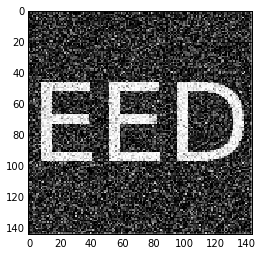

In [104]:
imgplot = plt.imshow(img, cm.Greys_r, interpolation='none', vmin = 0, vmax = 255)

In [111]:
dx, dt = 1,0.1

In [179]:
edge_threshold = 5; lsq = edge_threshold**2

In [186]:
u = np.copy(img).astype(float)

In [163]:
d = np.zeros((height, width))

In [86]:
def do_step_reflected_boundary_linear_homogeneous(u):
        
    for i, u_x in np.ndenumerate(u):
        if i[0] - 1 < 0:
            left = u[(i[0]+1, i[1])]
        else:
            left = u[(i[0]-1, i[1])]
        if i[0] + 1 > u.shape[1]-1:
            right = u[(i[0]-1, i[1])]
        else:
            right = u[(i[0]+1, i[1])]
        if i[1] - 1 < 0:
            up = u[(i[0], i[1]+1)]
        else:
            up = u[(i[0], i[1]-1)]
        if i[1] + 1 > u.shape[0]-1:
            down = u[(i[0], i[1]-1)]
        else:
            down = u[(i[0], i[1]+1)]
        
        d[i] = up + down + left + right - (4 * u_x)
        d[i] *= dt
    u += d


In [182]:
def do_step_reflected_boundary_nonlinear_isotropic(u):
    pad_u = np.pad(u, 1, 'reflect')
    
    for i, u_i in np.ndenumerate(u):
        # translate to padded co-ordinates
        i0 = i[0]+1
        i1 = i[1]+1
        
        # get values of neighboring pixels for finite differences
        left      = pad_u[i0-1, i1]
        right     = pad_u[i0+1, i1]
        up        = pad_u[i0, i1-1]
        down      = pad_u[i0, i1+1]
        upleft    = pad_u[i0-1, i1-1]
        upright   = pad_u[i0+1, i1-1]
        downleft  = pad_u[i0-1, i1+1]
        downright = pad_u[i0+1, i1+1]

                       
        # approximate first derivatives via central differences
        u_x = 0.5 * (right - left)
        u_y = 0.5 * (down - up)
        
        # approximate second derivatives
        u_xx = right + left - 2*u_i
        u_yy = up    + down - 2*u_i
        u_xy = 0.25 * (upleft + downright - upright - downleft)
        
        # Perona-Malik diffusion tensor
        mag_grad_u_sq = (u_x**2 + u_y**2)
        G = 1.0/(1.0 + mag_grad_u_sq/lsq)
        gprime = -lsq / ((mag_grad_u_sq + lsq)**2)
            
        
        # div(g(|grad(u)|^2)*grad(u)) = grad(g(|grad(u)|^2)) . grad(u) + g(|grad(u)|^2) * div(grad(u))
        d[i] = up + down + left + right - (4 * u_i)
        d[i] *= G
        d[i] += gprime*(u_x*(2*u_x*u_xx + 2*u_y*u_xy) + u_y*(2*u_x*u_xy + 2*u_y*u_yy))
        d[i] *= dt
    u += d


In [105]:
def show(img):
    plt.imshow(img.reshape(height,width), cm.Greys_r, interpolation='none', vmin = 0, vmax = 255)

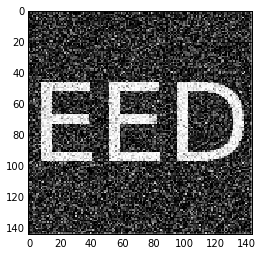

In [187]:
show(u) # Before

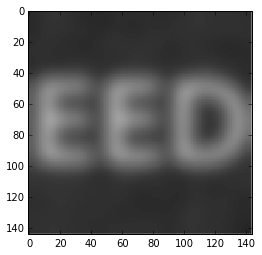

In [189]:
show(u) # After

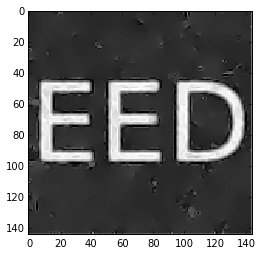

In [195]:
u = np.copy(img).astype(float)
u = ndimage.gaussian_filter(u, sigma=1)
for i in xrange(10*20): do_step_reflected_boundary_nonlinear_isotropic(u)
show(u)

In [188]:
for i in xrange(10*20): do_step_reflected_boundary_linear_homogeneous(u)

In [129]:
np.max(u)

253.64919238916195

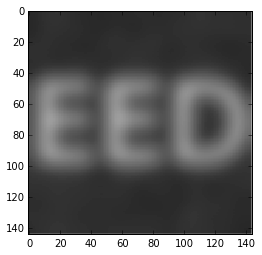

In [190]:
with_blur = ndimage.gaussian_filter(img, sigma=np.sqrt(2*20)); show(with_blur)

In [140]:
((with_blur - u) ** 2).mean(axis=None)

15.146947291544514

In [161]:
A = np.array([1,2,3,4,5,6,7,8,9]).reshape((3,3))
A = np.pad(A, 1, 'reflect')

A[0,2]

5

In [159]:
A

array([[5, 4, 5, 6, 5],
       [2, 1, 2, 3, 2],
       [5, 4, 5, 6, 5],
       [8, 7, 8, 9, 8],
       [5, 4, 5, 6, 5]])